# This is my code here on out


=================================================================|===================================



In [1]:
import time, random, numpy as np, math, os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

# Prefer Apple Silicon MPS, else CUDA, else CPU
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu")
)
print("Using device:", device)


Using device: mps


100%|██████████████████████████████████| 9.91M/9.91M [00:10<00:00, 966kB/s]
100%|█████████████████████████████████| 28.9k/28.9k [00:00<00:00, 92.7kB/s]
100%|██████████████████████████████████| 1.65M/1.65M [00:02<00:00, 716kB/s]
100%|█████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.61MB/s]

Train size: 60000, Test size: 10000


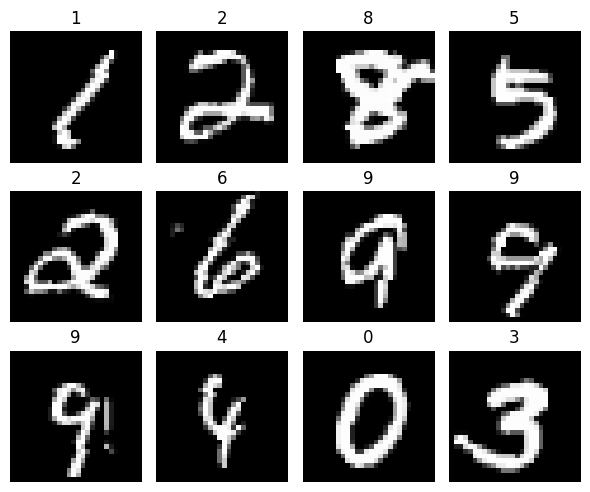

In [2]:
# Light affine aug helps reach 99.4% reliably while staying simple
transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.98, 1.02)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_ds = datasets.MNIST("./data", train=True,  download=True, transform=transform_train)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform_test)

is_mps = (device.type == "mps")
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True,  num_workers=2, pin_memory=not is_mps)
test_loader  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=2, pin_memory=not is_mps)

print(f"Train size: {len(train_ds)}, Test size: {len(test_ds)}")

# Quick peek (optional)
batch_imgs, batch_lbls = next(iter(train_loader))
fig = plt.figure(figsize=(6,5))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(batch_imgs[i].squeeze(0), cmap="gray")
    plt.title(batch_lbls[i].item())
    plt.axis("off")
plt.tight_layout()
plt.show()


In [3]:
# class MNIST_99p4_U20K(nn.Module):
#     """
#     Params ~<20K. Uses Conv+BN+ReLU, 1x1 transitions, MaxPool(2), light Dropout.
#     """
#     def __init__(self, p_drop=0.05):
#         super().__init__()
#         # Block A
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
#         self.bn1   = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16,16, kernel_size=3, padding=1)
#         self.bn2   = nn.BatchNorm2d(16)
#         self.pool1 = nn.MaxPool2d(2)        # 28->14
#         self.tr1   = nn.Conv2d(16,12, kernel_size=1)
#         self.drop1 = nn.Dropout(p_drop)

#         # Block B
#         self.conv3 = nn.Conv2d(12,24, kernel_size=3, padding=1)
#         self.bn3   = nn.BatchNorm2d(24)
#         self.conv4 = nn.Conv2d(24,24, kernel_size=3, padding=1)
#         self.bn4   = nn.BatchNorm2d(24)
#         self.pool2 = nn.MaxPool2d(2)        # 14->7
#         self.tr2   = nn.Conv2d(24,20, kernel_size=1)
#         self.drop2 = nn.Dropout(p_drop)

#         # Head (FC). Optional GAP head commented below.
#         self.fc    = nn.Linear(20*7*7, 10)

#         # (Optional GAP head – swap with FC if you prefer)
#         # self.gap = nn.AdaptiveAvgPool2d(1)
#         # self.classifier = nn.Conv2d(20, 10, kernel_size=1)

#     def forward(self, x):
#         # Block A
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool1(x)
#         x = self.tr1(x)
#         x = self.drop1(x)

#         # Block B
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = self.pool2(x)
#         x = self.tr2(x)
#         x = self.drop2(x)

#         # Head A (FC)
#         x = torch.flatten(x, 1)     # [N, 980]
#         x = self.fc(x)              # [N, 10] logits
#         return x

class MNIST_GAP_U18K(nn.Module):
    """
    <18K params (~14.5K). Conv+BN+ReLU, 1x1 transitions, MaxPool(2), Dropout, GAP head.
    Shape flow:
      Input  : 1×28×28
      BlockA : 1→16 conv → 16×28×28
             : 16→16 conv → 16×28×28
             : MaxPool(2) → 16×14×14
             : 1×1 conv   → 12×14×14
      BlockB : 12→28 conv → 28×14×14
             : 28→28 conv → 28×14×14
             : MaxPool(2) → 28×7×7
             : 1×1 conv   → 32×7×7
      Head   : GAP → 32×1×1 → 1×1 conv (32→10) → logits
    """
    def __init__(self, p_drop=0.05):
        super().__init__()
        # Block A
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2)
        self.tr1   = nn.Conv2d(16, 12, 1)
        self.drop1 = nn.Dropout(p_drop)

        # Block B
        self.conv3 = nn.Conv2d(12, 28, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(28)
        self.conv4 = nn.Conv2d(28, 28, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(28)
        self.pool2 = nn.MaxPool2d(2)
        self.tr2   = nn.Conv2d(28, 32, 1)
        self.drop2 = nn.Dropout(p_drop)

        # Head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Conv2d(32, 10, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x))); x = self.pool1(x)
        x = self.tr1(x); x = self.drop1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x))); x = self.pool2(x)
        x = self.tr2(x); x = self.drop2(x)

        x = self.gap(x)
        x = self.classifier(x).squeeze(-1).squeeze(-1)
        return x

# model = MNIST_99p4_U20K().to(device)
model = MNIST_GAP_U18K().to(device)


# Parameter budget check (< 20k)
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable params:", param_count)
#assert param_count < 20_000, "Parameter budget exceeded!"



Trainable params: 14254


In [4]:
criterion = nn.CrossEntropyLoss()

# SGD + momentum (mentor optimizer), Nesterov + WD for stability
optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9, nesterov=True, weight_decay=5e-4)

# OneCycleLR: great for <20 epochs, step PER BATCH
epochs = 15  # keep < 20 per assignment
steps_per_epoch = len(train_loader)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.3,              # try 0.25–0.35 if needed
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    anneal_strategy="cos",
    div_factor=10.0,         # initial LR = max_lr / div_factor
    final_div_factor=100.0,  # final LR = initial / final_div_factor
)

# --- Alternative: StepLR (per-epoch) ---
# optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9, nesterov=True, weight_decay=5e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # call scheduler.step() AFTER each epoch
# epochs = 15


In [6]:
def get_correct(pred, y):
    return pred.argmax(dim=1).eq(y).sum().item()

def train_one_epoch(model, loader, optimizer, scheduler, criterion, device):
    model.train()
    running_loss, correct, processed = 0.0, 0, 0
    pbar = tqdm(loader, leave=False)
    for batch_idx, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        # OneCycleLR: step PER BATCH (comment this if you switch to StepLR)
        scheduler.step()

        running_loss += loss.item()
        correct      += get_correct(logits, y)
        processed    += x.size(0)
        pbar.set_description(f"Train: Loss={loss.item():.4f} Acc={100*correct/processed:.2f}%")

    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / processed
    return avg_loss, acc

@torch.no_grad()
def evaluate(model, device, loader, criterion):
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss   = criterion(logits, y)
        loss_sum += loss.item() * x.size(0)  # sample-weighted
        correct  += get_correct(logits, y)
        total    += x.size(0)
    return loss_sum / total, 100.0 * correct / total


In [7]:
train_losses, test_losses = [], []
train_accs,   test_accs   = [], []

for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    te_loss, te_acc = evaluate(model, device, test_loader,  criterion)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);  test_accs.append(te_acc)

    # If you switch to StepLR alternative above, step PER EPOCH here:
    # scheduler.step()

    print(f"[TRAIN] acc: {tr_acc:.2f}%  loss: {tr_loss:.4f}")
    print(f"[TEST ] acc: {te_acc:.2f}%  loss: {te_loss:.4f}")

print("Best test acc:", max(test_accs))


Epoch 1/15


[TRAIN] acc: 73.42%  loss: 0.7723
[TEST ] acc: 79.57%  loss: 0.7070
Epoch 2/15


[TRAIN] acc: 95.78%  loss: 0.1429
[TEST ] acc: 67.40%  loss: 0.9718
Epoch 3/15


[TRAIN] acc: 96.71%  loss: 0.1096
[TEST ] acc: 90.45%  loss: 0.2821
Epoch 4/15


[TRAIN] acc: 97.06%  loss: 0.0964
[TEST ] acc: 97.23%  loss: 0.0829
Epoch 5/15


[TRAIN] acc: 97.37%  loss: 0.0882
[TEST ] acc: 96.98%  loss: 0.0966
Epoch 6/15


[TRAIN] acc: 97.58%  loss: 0.0800
[TEST ] acc: 97.48%  loss: 0.0795
Epoch 7/15


[TRAIN] acc: 97.77%  loss: 0.0728
[TEST ] acc: 95.61%  loss: 0.1434
Epoch 8/15


[TRAIN] acc: 97.88%  loss: 0.0699
[TEST ] acc: 97.67%  loss: 0.0694
Epoch 9/15


[TRAIN] acc: 98.09%  loss: 0.0645
[TEST ] acc: 96.93%  loss: 0.1034
Epoch 10/15


[TRAIN] acc: 98.17%  loss: 0.0613
[TEST ] acc: 98.26%  loss: 0.0575
Epoch 11/15


[TRAIN] acc: 98.34%  loss: 0.0562
[TEST ] acc: 98.77%  loss: 0.0417
Epoch 12/15


[TRAIN] acc: 98.53%  loss: 0.0502
[TEST ] acc: 98.78%  loss: 0.0403
Epoch 13/15


[TRAIN] acc: 98.62%  loss: 0.0459
[TEST ] acc: 99.05%  loss: 0.0334
Epoch 14/15


[TRAIN] acc: 98.86%  loss: 0.0388
[TEST ] acc: 99.36%  loss: 0.0226
Epoch 15/15


[TRAIN] acc: 99.00%  loss: 0.0343
[TEST ] acc: 99.42%  loss: 0.0201
Best test acc: 99.42


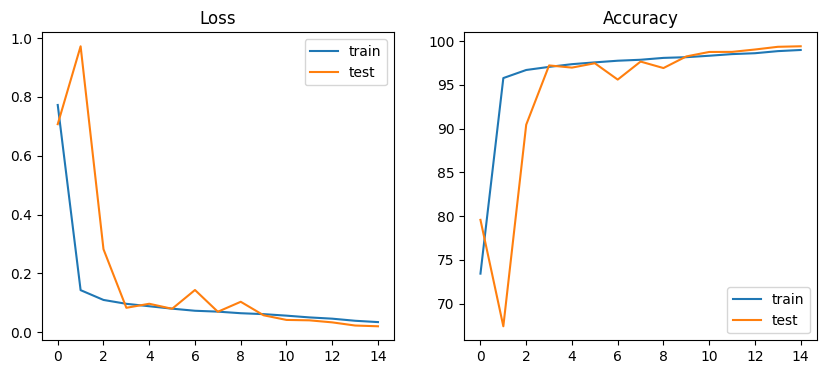

==== README Snippets ====
Total Parameter Count: 14254
Batch Normalization: Yes (after each conv)
Dropout: Yes (p=0.05 after each block)
Head: Fully Connected (980 -> 10) [GAP option available]


In [8]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(train_losses, label="train"); axs[0].plot(test_losses, label="test")
axs[0].set_title("Loss"); axs[0].legend()
axs[1].plot(train_accs, label="train"); axs[1].plot(test_accs, label="test")
axs[1].set_title("Accuracy"); axs[1].legend()
plt.show()

print("==== README Snippets ====")
print(f"Total Parameter Count: {param_count}")
print("Batch Normalization: Yes (after each conv)")
print("Dropout: Yes (p=0.05 after each block)")
print("Head: Fully Connected (980 -> 10) [GAP option available]")
